<a href="https://colab.research.google.com/github/itsayaanpatel/NTSB-Analysis/blob/main/Practicum_1mostly%20completeipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

url = "https://raw.githubusercontent.com/itsayaanpatel/NTSB-Analysis/main/Downloads/NTSBdata/NTSBAviationData.csv"
df = pd.read_csv(url, encoding='latin1', low_memory=False)

#latin1 is used to load data without crashing
# df = pd.read_csv("NTSBAviationData.csv", low_memory=False, encoding="latin1")  # remove or comment this line

# make column names lowercase and replace spaces dots with underscores
new_cols = []
for col in df.columns:
    col = col.strip().lower()
    col = col.replace(" ", "_").replace(".", "_")
    new_cols.append(col)
df.columns = new_cols

# convert dates
df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")

# convert injury columns to numbers
injury_cols = ["total_fatal_injuries","total_serious_injuries","total_minor_injuries","total_uninjured"]
for col in injury_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# drop rows without event_date
df = df.dropna(subset=["event_date"])

# clip extreme outliers at the 99th percentile
for col in injury_cols:
    if col in df.columns:
        upper = df[col].quantile(0.99)
        df[col] = np.where(df[col] > upper, upper, df[col])

print(df[injury_cols].describe())
# check shape (rows, columns)
print("Shape of data:", df.shape)

# check first few rows
print("\nFirst 5 rows:")
print(df.head())

# check missing values per column
print("\nMissing values per column:")
print(df.isna().sum())

# check data types
print("\nData types:")
print(df.dtypes)

# check unique values for key categorical columns
cat_cols = ["investigation_type","injury_severity","aircraft_category","make","weather_condition"]
for col in cat_cols:
    if col in df.columns:
        print(f"\nUnique values in {col}:")
        print(df[col].unique())

# check basic stats for numeric columns
print("\nNumeric summary:")
print(df.describe())


       total_fatal_injuries  total_serious_injuries  total_minor_injuries  \
count          77488.000000            76379.000000          76956.000000   
mean               0.435332                0.238351              0.300327   
std                0.973694                0.587873              0.701695   
min                0.000000                0.000000              0.000000   
25%                0.000000                0.000000              0.000000   
50%                0.000000                0.000000              0.000000   
75%                0.000000                0.000000              0.000000   
max                5.000000                3.000000              4.000000   

       total_uninjured  
count     82977.000000  
mean          4.491112  
std          19.884282  
min           0.000000  
25%           0.000000  
50%           1.000000  
75%           2.000000  
max         151.000000  
Shape of data: (88889, 31)

First 5 rows:
         event_id investigation_type ac

**Question 1:**


Create an executive dashboard (i.e. organized visualizations that are informative) showing the current state of aviation safety. Include:


A line chart showing accidents vs. incidents for the most recent 20 years available in the dataset.
A proportion chart comparing fatal vs. non-fatal events over time.
A gauge or KPI card showing the current "safety score" (you define this metric). Ensure that you clearly define the metric and what factors are being considered in your calculation.
Insight Goal: Show how aviation safety have evolved. Has it progress or stagnated in any areas? Establish whether safety is improving and identify any concerning trends that need immediate attention. Explain your results.


/tmp/ipython-input-714611294.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recent['fatal'] = df_recent['total_fatal_injuries'].fillna(0).apply(lambda x: 1 if x > 0 else 0)


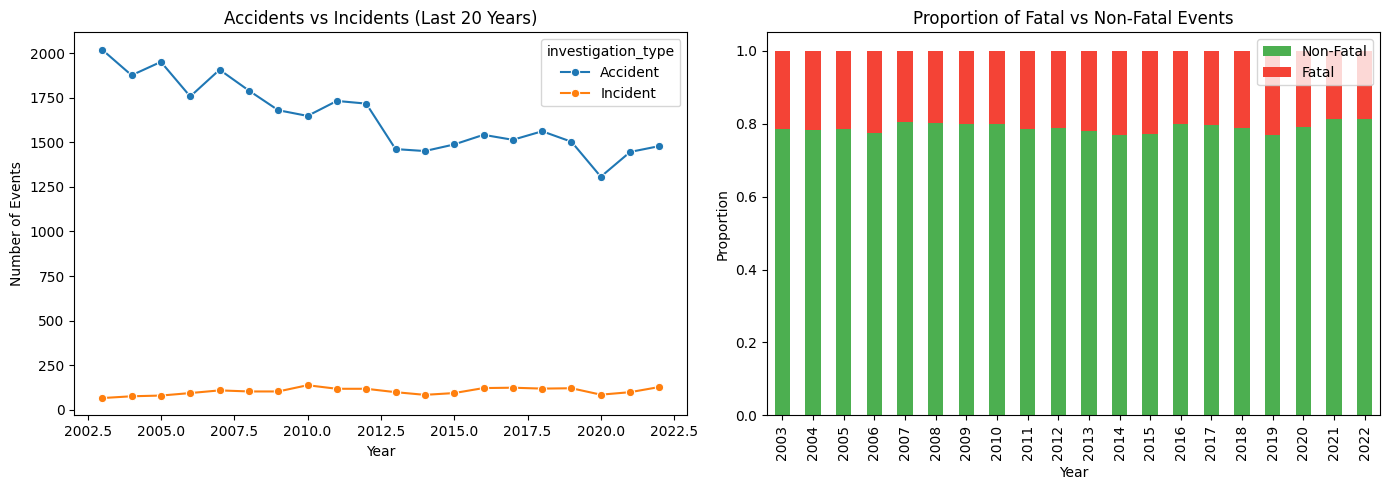

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

df['year'] = df['event_date'].dt.year

recent_years = sorted(df['year'].dropna().unique())[-20:]
df_recent = df[df['year'].isin(recent_years)]

acc_inc_trend = df_recent.groupby(['year', 'investigation_type']).size().reset_index(name='count')

df_recent['fatal'] = df_recent['total_fatal_injuries'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
fatal_trend = df_recent.groupby(['year', 'fatal']).size().reset_index(name='count')


# Safety score is % of non-fatal events over total events (scaled to 100)
total_events = len(df_recent)
non_fatal_events = len(df_recent[df_recent['fatal'] == 0])
safety_score = round((non_fatal_events / total_events) * 100, 2)



plt.figure(figsize=(14, 5))

# 1. Line Chart: Accidents vs Incidents
plt.subplot(1, 2, 1)
sns.lineplot(data=acc_inc_trend, x='year', y='count', hue='investigation_type', marker="o")
plt.title("Accidents vs Incidents (Last 20 Years)")
plt.ylabel("Number of Events")
plt.xlabel("Year")

# 2. Proportion Chart: Fatal vs Non-Fatal
plt.subplot(1, 2, 2)
fatal_pivot = fatal_trend.pivot(index='year', columns='fatal', values='count').fillna(0)
fatal_pivot = fatal_pivot.div(fatal_pivot.sum(axis=1), axis=0)
fatal_pivot.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#4CAF50','#F44336'])
plt.title("Proportion of Fatal vs Non-Fatal Events")
plt.ylabel("Proportion")
plt.xlabel("Year")
plt.legend(['Non-Fatal','Fatal'])

plt.tight_layout()
plt.show()


# 3. Gauge / KPI Card for Safety Score
fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=safety_score,
    title={'text': "Aviation Safety Score"},
    gauge={'axis': {'range': [0, 100]},
           'bar': {'color': "black"},
           'steps': [
               {'range': [0, 70], 'color': "red"},
               {'range': [70, 90], 'color': "yellow"},
               {'range': [90, 100], 'color': "lightgreen"}]}))

fig.show()


From the graph of accidents vs incidents over time, the first difference we can see is that there are a lot more accidents than incidents. Accidents show incidents that actually resulted in injury. Over time, we can see the number of accidents show a slight downward trend over the years, where as the number of incidents seems to be staying constant or a very minimal increase. When we look at the proportion of fatal vs. nonfatal events, it is apparent that nonfatal events make up a larger proportion of events (4/5) unlike fatal events which make up 1/5. From this, the aviation safety score (which is the number of nonfatal events over the fatal events) is 78.9, which is in the yellow range. This shows that the safety score should be higher and better provisions must be put into place.

# Question 2: Risk Factors:

Perform a multi-dimensional analysis using at least 4-5 visualizations that tell a compelling story about risk factors. Consider:

Which combinations of factors create the highest risk (e.g. Weather conditions, type of aircraft, purpose of flight, etc.)?
Are there "hidden" risk patterns that might not be obvious?
Did any risk evolve over time for different categories?
Insight Goal: Identify the specific combinations of factors that reveal the highest risk, and whether new risk patterns are emerging.

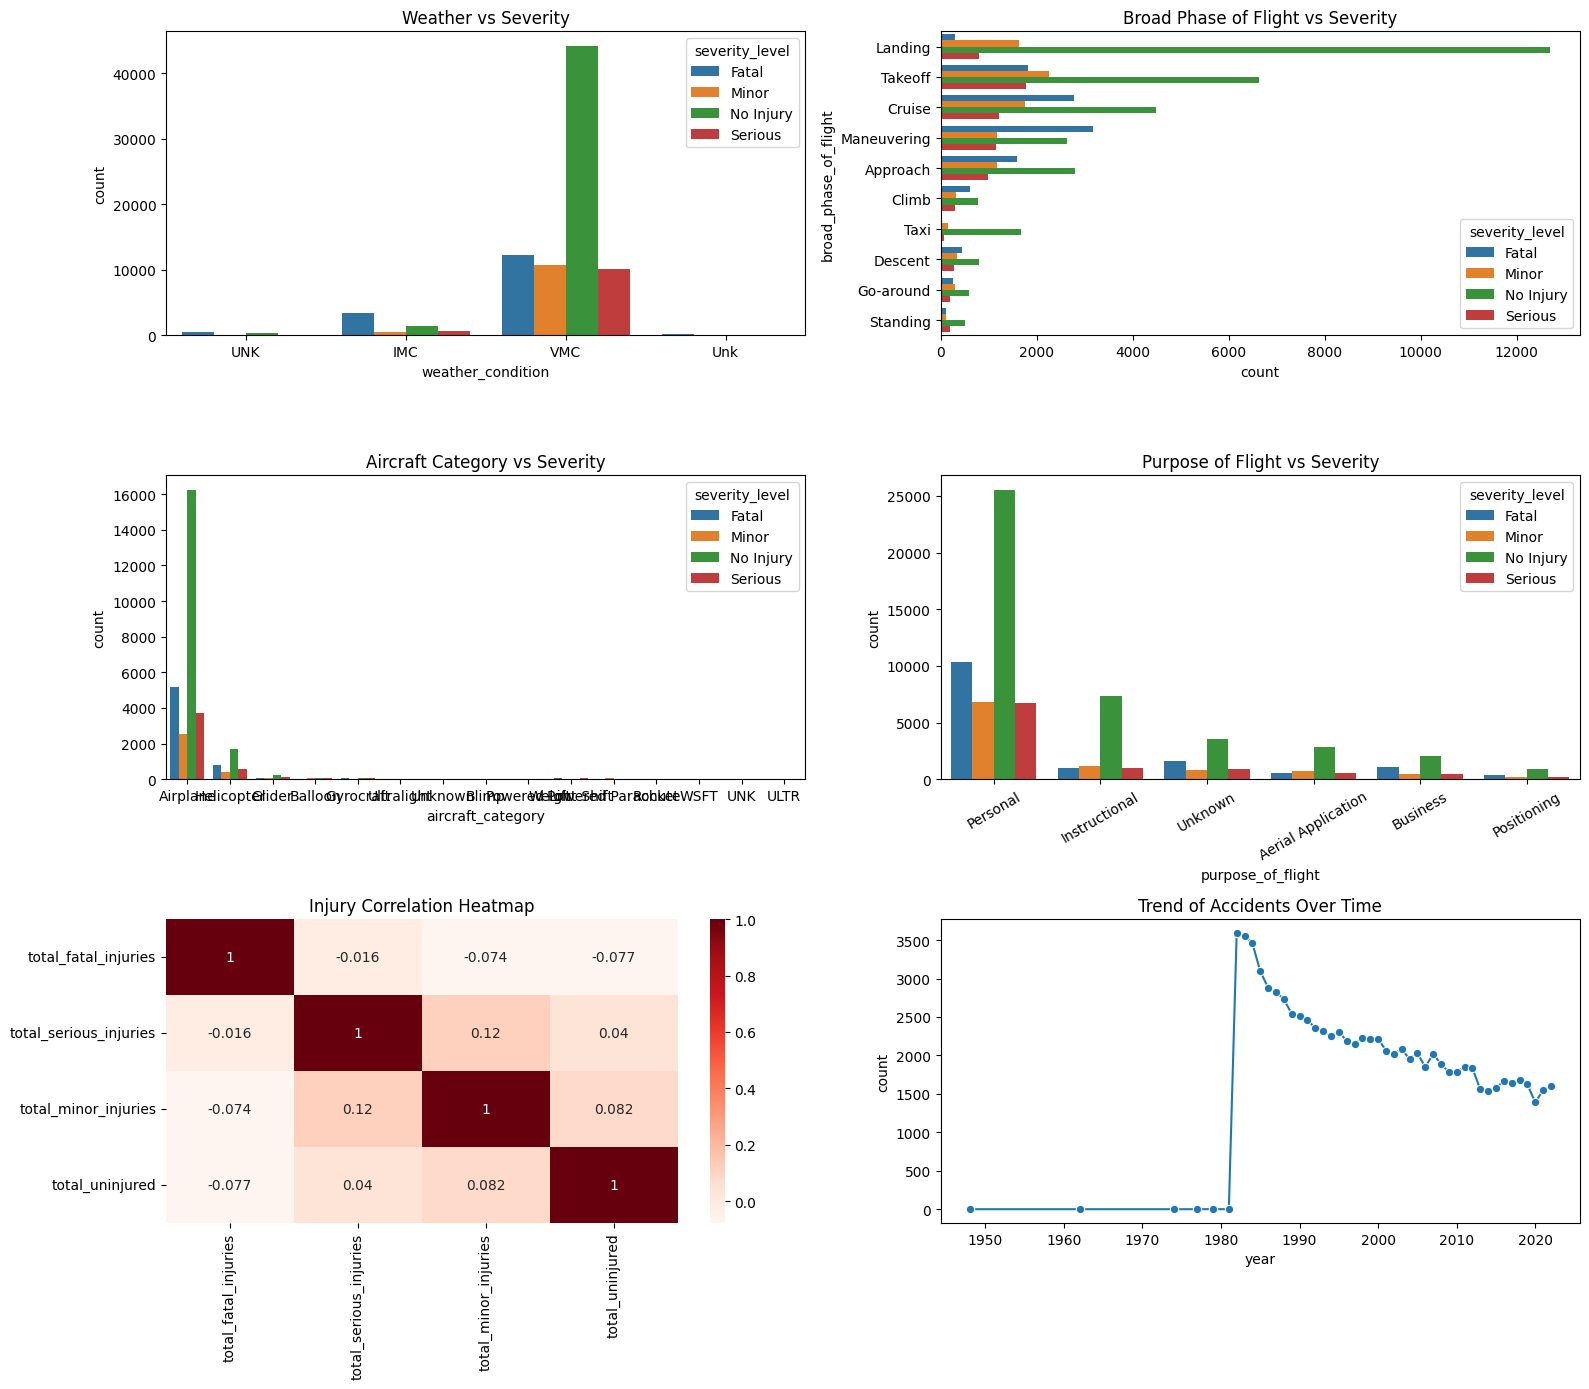

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define severity levels
def classify_severity(row):
    if row["total_fatal_injuries"] > 0:
        return "Fatal"
    elif row["total_serious_injuries"] > 0:
        return "Serious"
    elif row["total_minor_injuries"] > 0:
        return "Minor"
    else:
        return "No Injury"

df["severity_level"] = df.apply(classify_severity, axis=1)


fig, axes = plt.subplots(3, 2, figsize=(16,14))  # 3 rows × 2 columns

# 1. Weather vs Severity
sns.countplot(data=df, x="weather_condition", hue="severity_level", ax=axes[0,0])
axes[0,0].set_title("Weather vs Severity")

# 2. Broad Phase of Flight vs Severity
sns.countplot(
    data=df,
    y="broad_phase_of_flight",
    hue="severity_level",
    order=df["broad_phase_of_flight"].value_counts().index[:10],
    ax=axes[0,1]
)
axes[0,1].set_title("Broad Phase of Flight vs Severity")

# 3. Aircraft Category vs Severity
sns.countplot(data=df, x="aircraft_category", hue="severity_level", ax=axes[1,0])
axes[1,0].set_title("Aircraft Category vs Severity")

# 4. Purpose of Flight vs Severity
sns.countplot(
    data=df,
    x="purpose_of_flight",
    hue="severity_level",
    order=df["purpose_of_flight"].value_counts().index[:6],
    ax=axes[1,1]
)
axes[1,1].set_title("Purpose of Flight vs Severity")
axes[1,1].tick_params(axis="x", rotation=30)

# 5. Heatmap of correlations
corr = df[["total_fatal_injuries","total_serious_injuries",
           "total_minor_injuries","total_uninjured"]].corr()
sns.heatmap(corr, annot=True, cmap="Reds", ax=axes[2,0])
axes[2,0].set_title("Injury Correlation Heatmap")

# 6. Trend line (Accidents over time)
sns.lineplot(data=df.groupby("year").size().reset_index(name="count"),
             x="year", y="count", marker="o", ax=axes[2,1])
axes[2,1].set_title("Trend of Accidents Over Time")

plt.tight_layout()
plt.show()



# Key Findings:

1. The Most Dangerous Combinations

These are the specific situations where accidents (especially fatal ones) are most concentrated:

Airplanes face their highest risk during the Takeoff and Landing phases. The high volume of traffic and the complex, high-workload nature of these phases make them statistically the most dangerous combination for the largest aircraft category.

Helicopters have a high concentration of fatal accidents during Maneuvering. This highlights the inherent danger in low-altitude, high-precision operations specific to helicopters.

2. The Hidden (Proportional) Risks

These are the factors that are dangerous not because they happen often, but because they have the highest fatality rate per incident:

Poor Weather: While most accidents occur in VMC (good weather), operations in IMC (Instrument Meteorological Conditions) carry a disproportionately higher rate of Fatal outcomes. When weather is poor, the risk of death skyrockets.

Specialized Flights: Missions like Aerial Application (crop dusting) and Instructional flights have a much higher proportion of Fatal/Serious accidents than common "Personal" flights, indicating a high inherent risk for these operational roles.

3. Evolving Risk

The time-series plot reveals how risk is changing:

A downward trend in Fatal accidents suggests safety initiatives and technology are working to prevent the worst outcomes.


#Question 3: Phase of Flight Analysis

Analyze the flight phases to determine if there are any patterns when most accidents/incidents occur.
Create a detailed breakdown showing which phases of flight most events transpire.
For each phase of flight, analyze the data across another dimension in the data to draw insights.


Phase summary (top 10):
          phase  events  fatal  severe  fatal_rate  severe_rate
11      Unknown   27713  25916   26089    0.935157     0.941399
5       Landing   15428  15073   15073    0.976990     0.976990
9       Takeoff   12493  12133   12133    0.971184     0.971184
2        Cruise   10269   9904    9904    0.964456     0.964456
6   Maneuvering    8144   8107    8107    0.995457     0.995457
0      Approach    6546   6338    6338    0.968225     0.968225
1         Climb    2034   1850    1850    0.909538     0.909538
10         Taxi    1958   1783    1783    0.910623     0.910623
3       Descent    1887   1778    1778    0.942236     0.942236
4     Go-Around    1353   1338    1338    0.988914     0.988914


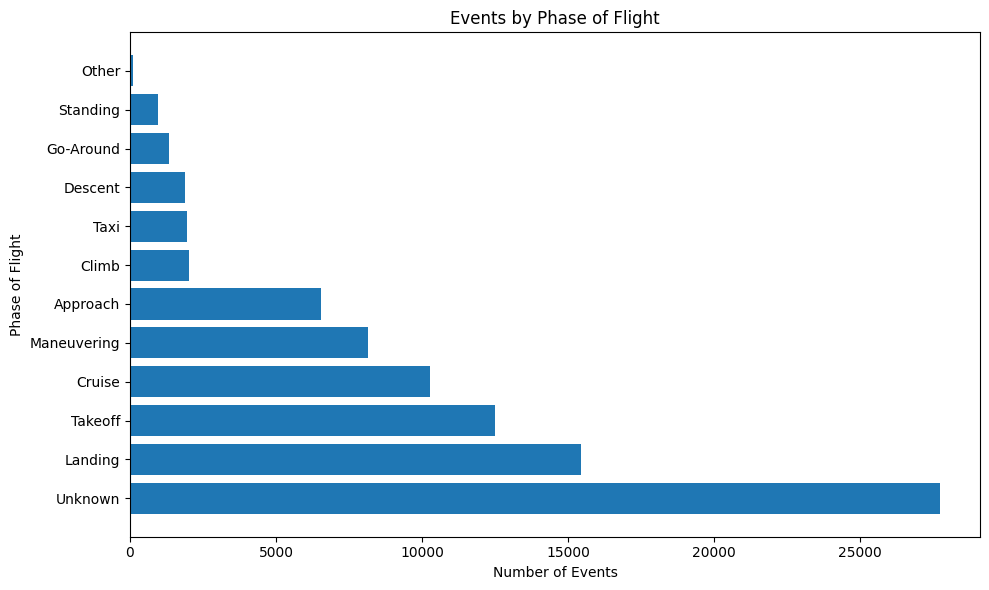

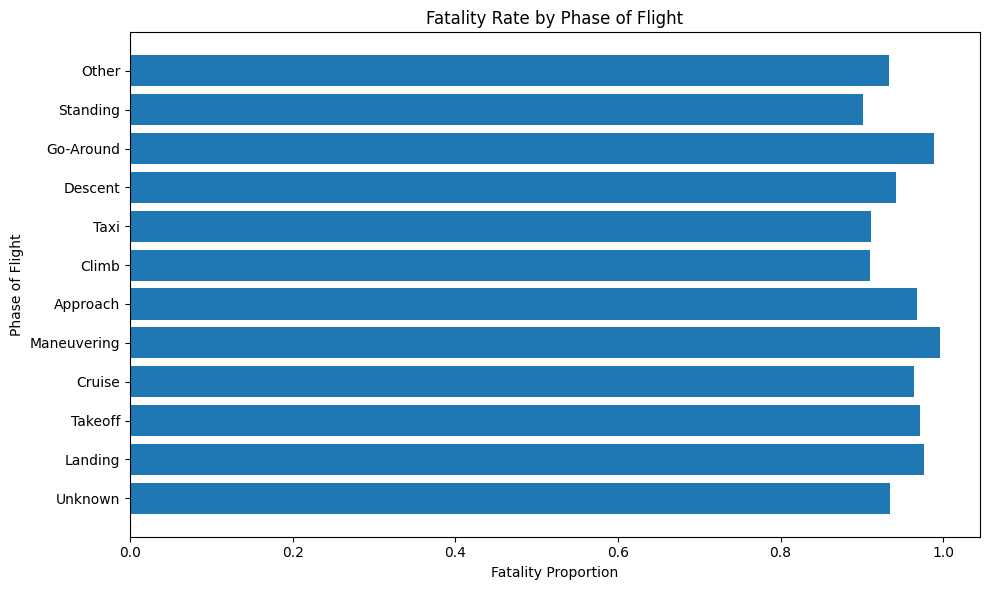

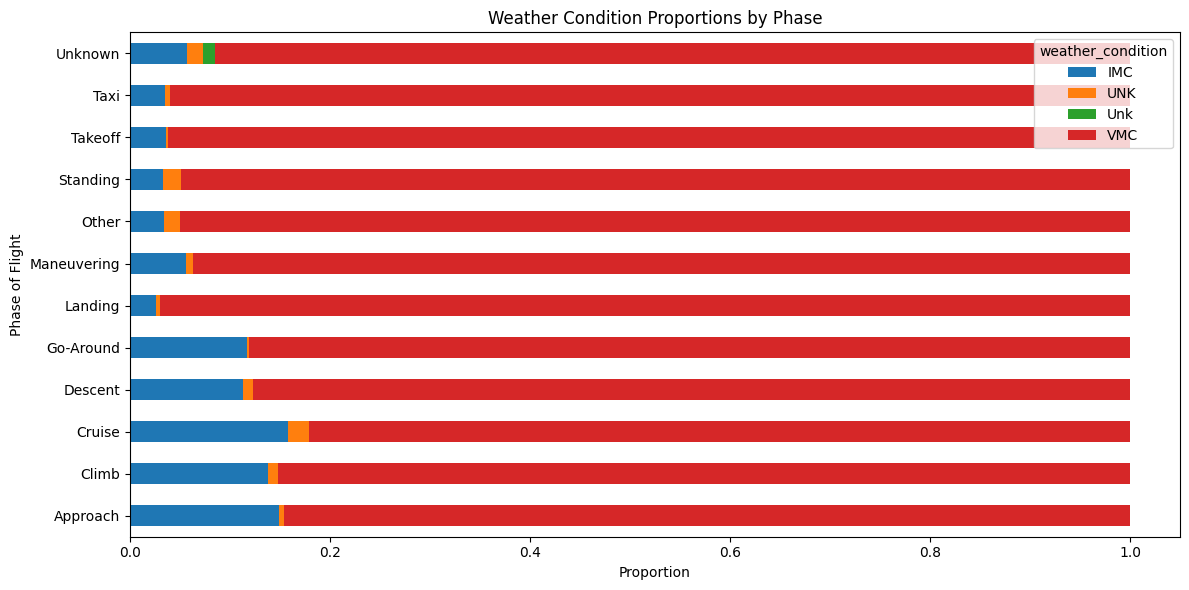

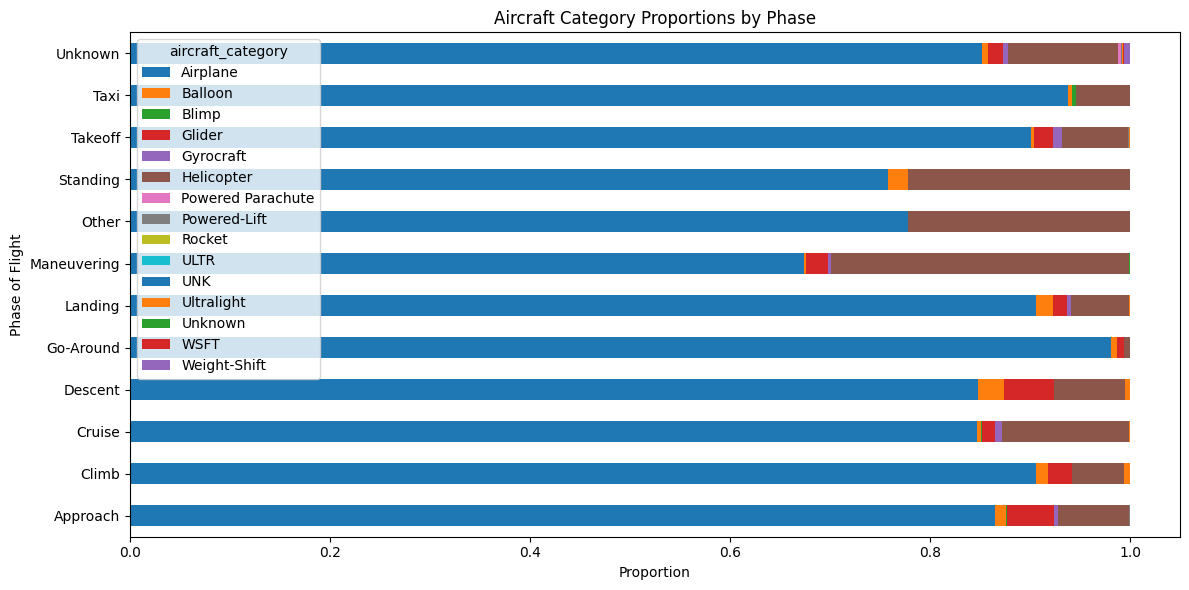

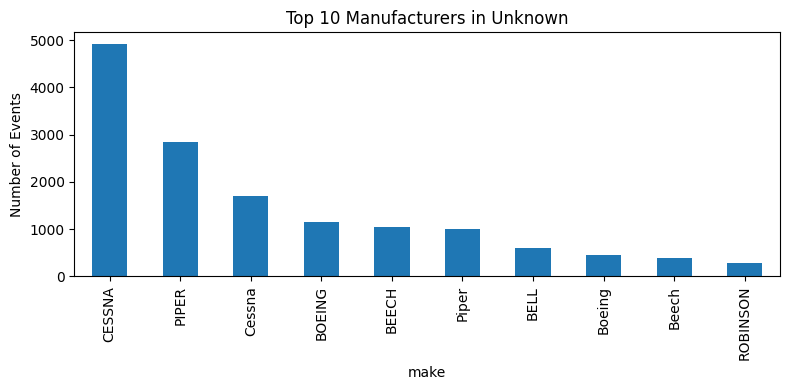

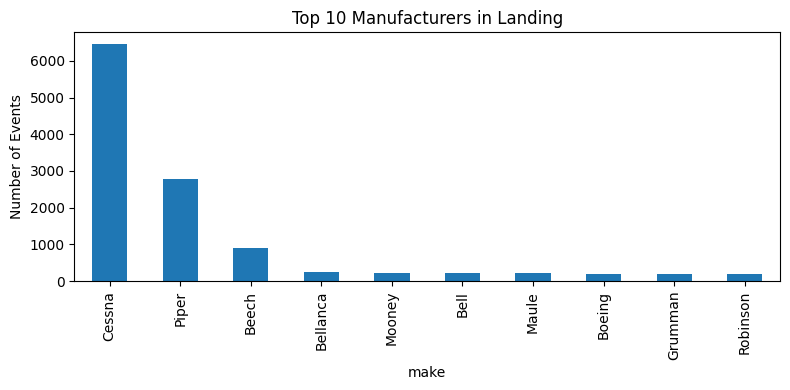

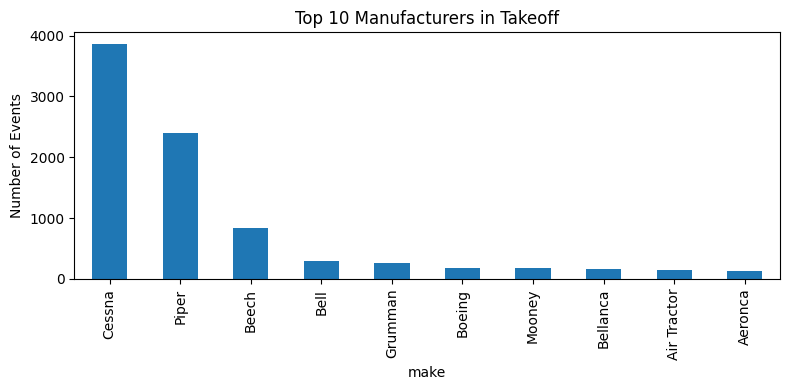

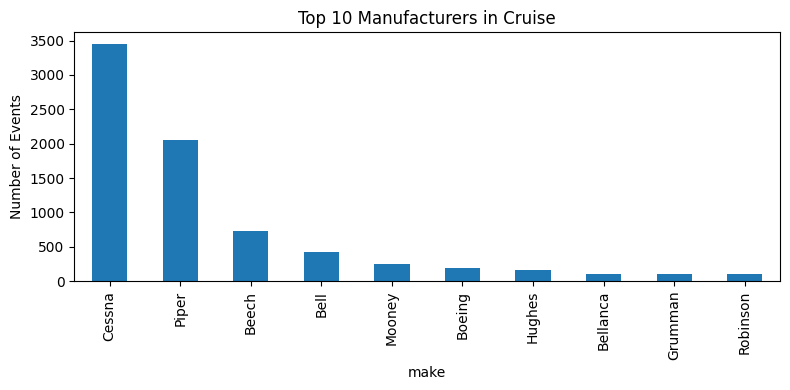

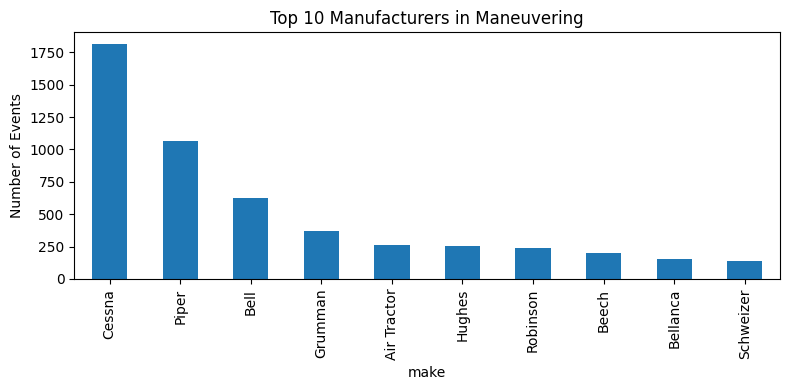

In [ ]:
import os

out_dir = "phase_analysis_outputs"
os.makedirs(out_dir, exist_ok=True)

df["phase"] = df["broad_phase_of_flight"].astype(str).str.strip().str.title()
df["phase"] = df["phase"].replace("Nan", "Unknown")

# make injury flags for analysis
df["is_fatal"] = df["injury_severity"].astype(str).str.lower().str.contains("fatal", na=False)
df["is_serious"] = df["injury_severity"].astype(str).str.lower().str.contains("serious", na=False)
df["is_severe"] = df["is_fatal"] | df["is_serious"]

# 1. Count events by phase
phase_summary = df.groupby("phase").agg(
    events=("phase", "count"),
    fatal=("is_fatal", "sum"),
    severe=("is_severe", "sum")
).reset_index()

phase_summary["fatal_rate"] = phase_summary["fatal"] / phase_summary["events"]
phase_summary["severe_rate"] = phase_summary["severe"] / phase_summary["events"]

# sort by number of events
phase_summary = phase_summary.sort_values("events", ascending=False)

print("Phase summary (top 10):")
print(phase_summary.head(10))

# plot number of events per phase
plt.figure(figsize=(10,6))
plt.barh(phase_summary["phase"], phase_summary["events"])
plt.xlabel("Number of Events")
plt.ylabel("Phase of Flight")
plt.title("Events by Phase of Flight")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "phase_counts.png"))
plt.show()

# plot fatality proportion per phase
plt.figure(figsize=(10,6))
plt.barh(phase_summary["phase"], phase_summary["fatal_rate"])
plt.xlabel("Fatality Proportion")
plt.ylabel("Phase of Flight")
plt.title("Fatality Rate by Phase of Flight")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "phase_fatal_rate.png"))
plt.show()

# 2. Look at another dimension: weather condition
weather_phase = pd.crosstab(df["phase"], df["weather_condition"])
weather_phase.to_csv(os.path.join(out_dir, "phase_by_weather.csv"))

weather_phase_prop = weather_phase.div(weather_phase.sum(axis=1), axis=0)

weather_phase_prop.plot(kind="barh", stacked=True, figsize=(12,6))
plt.xlabel("Proportion")
plt.ylabel("Phase of Flight")
plt.title("Weather Condition Proportions by Phase")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "phase_by_weather.png"))
plt.show()

# 3. Another dimension: aircraft category
cat_phase = pd.crosstab(df["phase"], df["aircraft_category"])
cat_phase.to_csv(os.path.join(out_dir, "phase_by_category.csv"))

cat_phase_prop = cat_phase.div(cat_phase.sum(axis=1), axis=0)

cat_phase_prop.plot(kind="barh", stacked=True, figsize=(12,6))
plt.xlabel("Proportion")
plt.ylabel("Phase of Flight")
plt.title("Aircraft Category Proportions by Phase")
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "phase_by_category.png"))
plt.show()

# 4. Look at top manufacturers in the 5 busiest phases
top_phases = phase_summary.head(5)["phase"].tolist()

for ph in top_phases:
    sub = df[df["phase"] == ph]
    top_makes = sub["make"].value_counts().head(10)
    top_makes.to_csv(os.path.join(out_dir, f"top_makes_in_{ph}.csv"))

    top_makes.plot(kind="bar", figsize=(8,4))
    plt.ylabel("Number of Events")
    plt.title(f"Top 10 Manufacturers in {ph}")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"top_makes_in_{ph}.png"))
    plt.show()

#Question 4: Aircraft Manufacturer Analysis

Conduct a fair but thorough comparative analysis of manufacturer and aircraft safety record with respect to accidents and incidents (both fatal and non-fatal)

4.1 Manufacturer Safety Comparison

Analyze aircraft models with disproportionately high accident or fatality rates. Investigate if certain model aircraft are problematic or if issues are brand-wide
Create a visualization showing whether these are concentrated in specific phases of flight
Analyze whether their safety record has improved, declined, or remained stable over time.
Note: You can narrow your analysis and discussion to 5 manufacturers. Visualize all results.

4.2 Investigate aircraft complexity and safety

Use number of engines and engine type as complexity indicators
Visualize whether more complex aircraft have different accident patterns
Compare accident severity across at least two aircraft categories


SECTION 4.1: MANUFACTURER SAFETY COMPARISON

Top 10 Manufacturers by Total Events:
make
Cessna     22227
Piper      12029
CESSNA      4922
Beech       4330
PIPER       2841
Bell        2134
Boeing      1594
BOEING      1151
Grumman     1094
Mooney      1092
Name: count, dtype: int64

Focusing on top 5 manufacturers: ['Cessna', 'Piper', 'CESSNA', 'Beech', 'PIPER']

MANUFACTURER SAFETY METRICS (Top 5)
Manufacturer  Total Events  Accidents  Incidents  Fatal Events  Total Fatalities  Fatal Event Rate (%)  Accident Rate (%)
      Cessna         22227      21973        254          3680              7327                 16.56              98.86
       Piper         12029      11885        144          2568              5206                 21.35              98.80
      CESSNA          4922       4820        102           956              1870                 19.42              97.93
       Beech          4330       4170        160          1245              2667                 28.75      

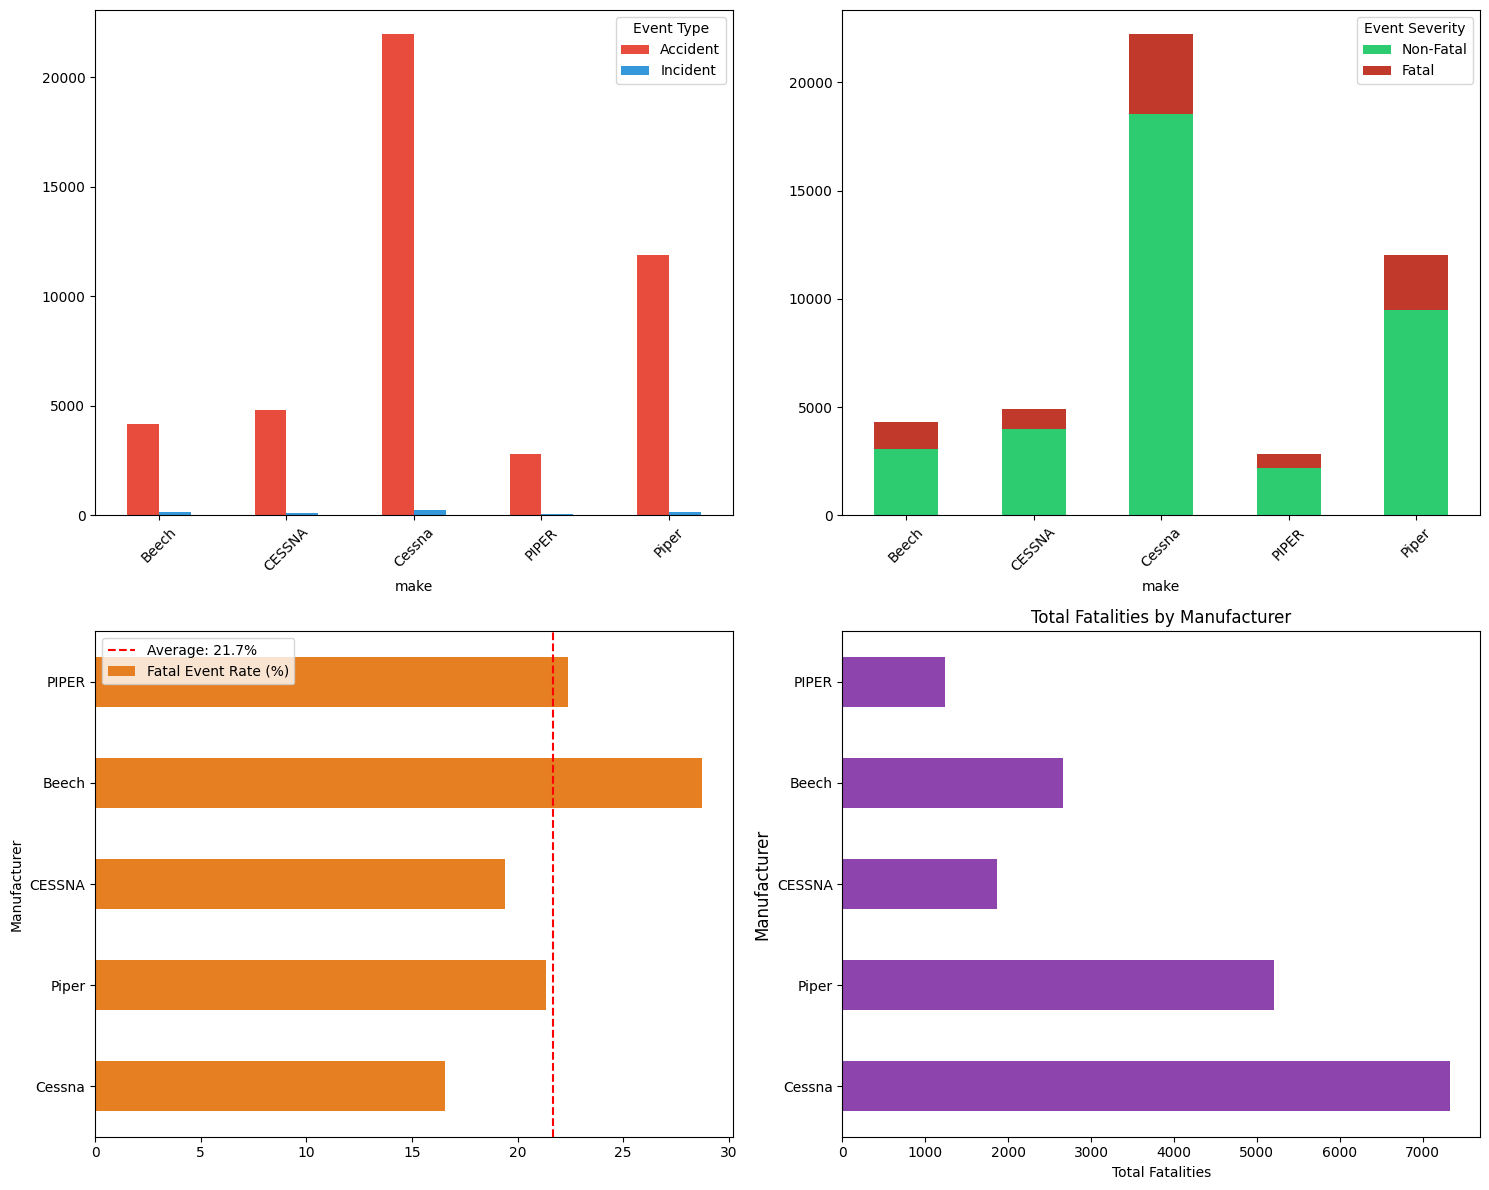


TOP MODELS BY MANUFACTURER (Accident Analysis)

Cessna:
----------------------------------------
  152: 2155 accidents, 222 fatal (349 deaths)
  172: 1250 accidents, 115 fatal (230 deaths)
  172N: 993 accidents, 173 fatal (365 deaths)
  150: 711 accidents, 58 fatal (78 deaths)
  172M: 663 accidents, 111 fatal (201 deaths)

Piper:
----------------------------------------
  PA-28-140: 809 accidents, 156 fatal (282 deaths)
  PA-18: 539 accidents, 53 fatal (82 deaths)
  PA-28-180: 498 accidents, 128 fatal (236 deaths)
  PA-28-161: 498 accidents, 101 fatal (210 deaths)
  PA-28-181: 472 accidents, 128 fatal (275 deaths)

CESSNA:
----------------------------------------
  172: 494 accidents, 96 fatal (167 deaths)
  152: 193 accidents, 28 fatal (41 deaths)
  182: 191 accidents, 56 fatal (108 deaths)
  172S: 182 accidents, 25 fatal (46 deaths)
  172N: 167 accidents, 30 fatal (63 deaths)

Beech:
----------------------------------------
  A36: 289 accidents, 103 fatal (228 deaths)
  58: 170 acci

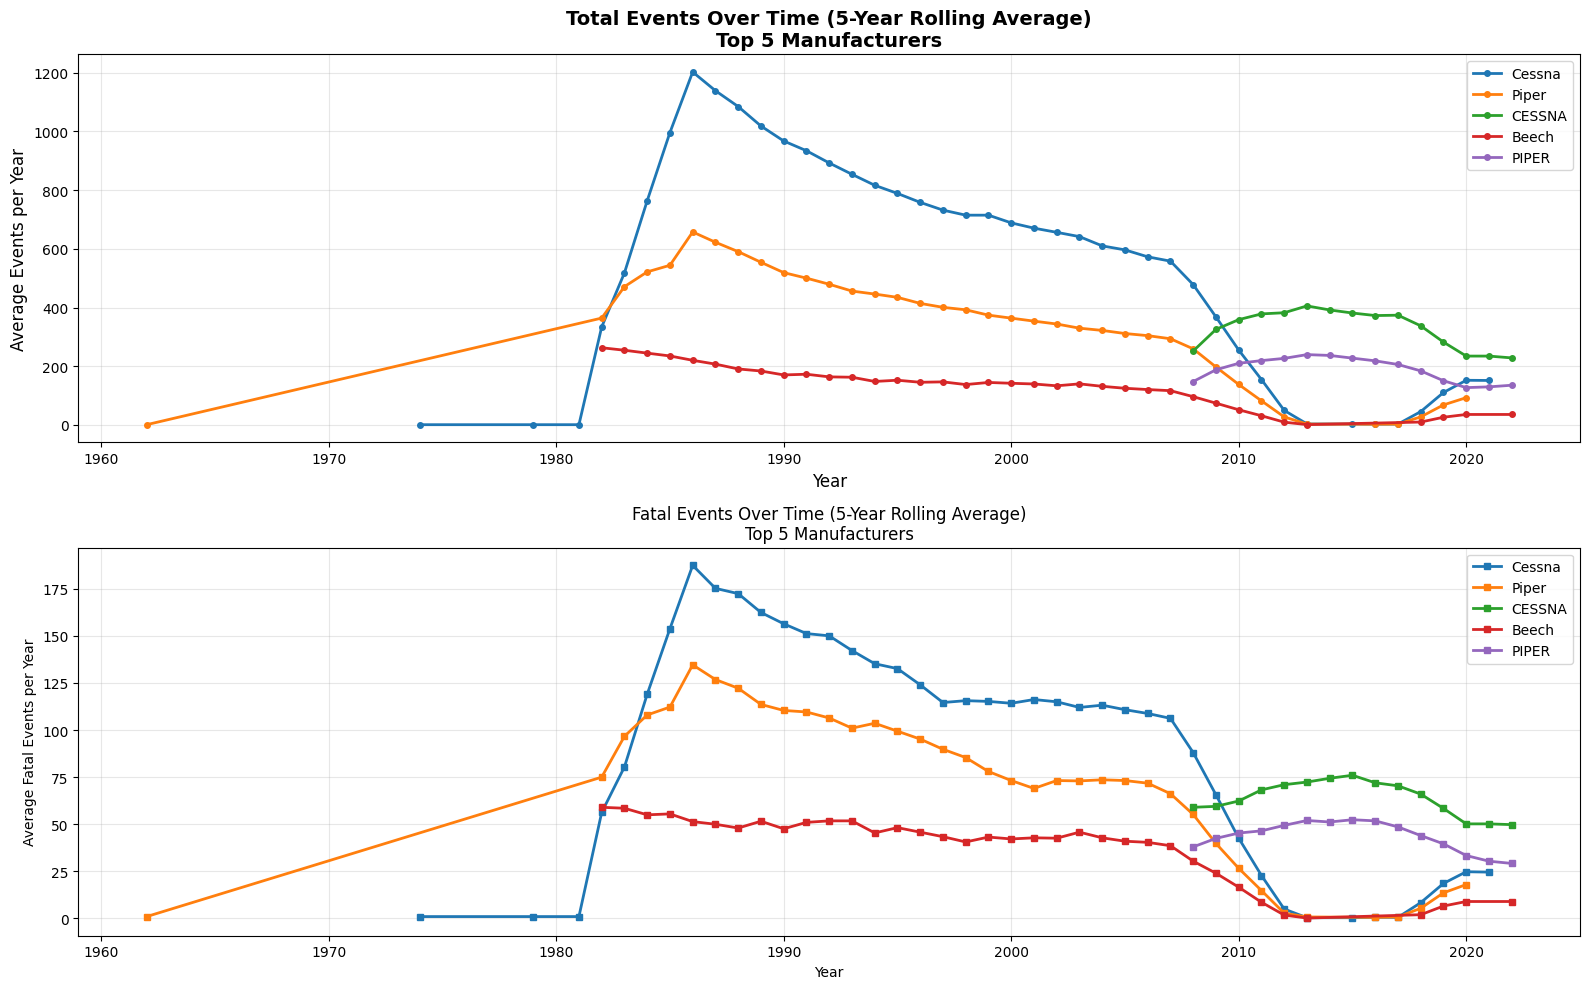


Safety Trend Analysis (Last 10 vs Previous 10 Years):

Cessna:
  Total events: -78.9% change ↓ IMPROVING
  Fatal events: -81.0% change
  Recent period: 768 events (125 fatal)
  Previous period: 3636 events (658 fatal)

Piper:
  Total events: -75.6% change ↓ IMPROVING
  Fatal events: -78.8% change
  Recent period: 472 events (92 fatal)
  Previous period: 1932 events (433 fatal)

CESSNA:
  Total events: +125.3% change ↑ WORSENING
  Fatal events: +150.2% change
  Recent period: 3409 events (683 fatal)
  Previous period: 1513 events (273 fatal)

Beech:
  Total events: -76.3% change ↓ IMPROVING
  Fatal events: -81.6% change
  Recent period: 180 events (45 fatal)
  Previous period: 760 events (245 fatal)

PIPER:
  Total events: +123.9% change ↑ WORSENING
  Fatal events: +141.9% change
  Recent period: 1964 events (450 fatal)
  Previous period: 877 events (186 fatal)


In [ ]:
#4.1
print("\n" + "="*80)
print("SECTION 4.1: MANUFACTURER SAFETY COMPARISON")
print("="*80)

# Clean up manufacturer names (remove leading/trailing spaces)
df['make'] = df['make'].str.strip()

# Count total events by manufacturer
manufacturer_counts = df['make'].value_counts()
print("\nTop 10 Manufacturers by Total Events:")
print(manufacturer_counts.head(10))

# Select top 5 manufacturers for detailed analysis
top_5_manufacturers = manufacturer_counts.head(5).index.tolist()
print(f"\nFocusing on top 5 manufacturers: {top_5_manufacturers}")

# Filter data for top 5 manufacturers
df_top5 = df[df['make'].isin(top_5_manufacturers)].copy()

# Create a binary column for fatal events
df_top5['is_fatal'] = df_top5['total_fatal_injuries'].fillna(0) > 0

# Calculate key metrics for each manufacturer
manufacturer_stats = []
for mfr in top_5_manufacturers:
    mfr_data = df_top5[df_top5['make'] == mfr]

    total_events = len(mfr_data)
    total_accidents = len(mfr_data[mfr_data['investigation_type'] == 'Accident'])
    total_incidents = len(mfr_data[mfr_data['investigation_type'] == 'Incident'])
    fatal_events = mfr_data['is_fatal'].sum()
    total_fatalities = mfr_data['total_fatal_injuries'].sum()

    manufacturer_stats.append({
        'Manufacturer': mfr,
        'Total Events': total_events,
        'Accidents': total_accidents,
        'Incidents': total_incidents,
        'Fatal Events': fatal_events,
        'Total Fatalities': int(total_fatalities),
        'Fatal Event Rate (%)': round(fatal_events / total_events * 100, 2),
        'Accident Rate (%)': round(total_accidents / total_events * 100, 2)
    })

stats_df = pd.DataFrame(manufacturer_stats)
print("\n" + "="*80)
print("MANUFACTURER SAFETY METRICS (Top 5)")
print("="*80)
print(stats_df.to_string(index=False))

# Visualization 1: Overall Event Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Total Events by Type
event_type_data = df_top5.groupby(['make', 'investigation_type']).size().unstack(fill_value=0)
event_type_data.plot(kind='bar', ax=axes[0, 0], color=['#e74c3c', '#3498db'])
plt.title('Total Events by Manufacturer (Accidents vs Incidents)')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Events')
axes[0, 0].legend(title='Event Type')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Fatal vs Non-Fatal Events
fatal_data = df_top5.groupby(['make', 'is_fatal']).size().unstack(fill_value=0)
fatal_data.columns = ['Non-Fatal', 'Fatal']
fatal_data.plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#c0392b'], stacked=True)
plt.title('Fatal vs Non-Fatal Events by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Events')
axes[0, 1].legend(title='Event Severity')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Fatal Event Rate
fatal_rate = stats_df.set_index('Manufacturer')['Fatal Event Rate (%)']
fatal_rate.plot(kind='barh', ax=axes[1, 0], color='#e67e22')
plt.title('Fatal Event Rate by Manufacturer (%)')
plt.xlabel('Fatal Event Rate (%)')
plt.ylabel('Manufacturer', fontsize=12)
axes[1, 0].axvline(x=fatal_rate.mean(), color='red', linestyle='--', label=f'Average: {fatal_rate.mean():.1f}%')
axes[1, 0].legend()

# Plot 4: Total Fatalities
total_fats = stats_df.set_index('Manufacturer')['Total Fatalities']
total_fats.plot(kind='barh', ax=axes[1, 1], color='#8e44ad')
plt.title('Total Fatalities by Manufacturer')
plt.xlabel('Total Fatalities')
plt.ylabel('Manufacturer')

plt.tight_layout()
plt.savefig('manufacturer_overview.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: manufacturer_overview.png")
plt.show()

print("\n" + "="*80)
print("TOP MODELS BY MANUFACTURER (Accident Analysis)")
print("="*80)

for mfr in top_5_manufacturers:
    print(f"\n{mfr}:")
    print("-" * 40)
    mfr_data = df_top5[df_top5['make'] == mfr]

    # Get top 5 models by accident count
    model_accidents = mfr_data[mfr_data['investigation_type'] == 'Accident']['model'].value_counts().head(5)

    for model, count in model_accidents.items():
        model_data = mfr_data[mfr_data['model'] == model]
        fatal_count = model_data['is_fatal'].sum()
        total_fats = int(model_data['total_fatal_injuries'].sum())
        print(f"  {model}: {count} accidents, {fatal_count} fatal ({total_fats} deaths)")

print("\n" + "="*80)
print("TEMPORAL TRENDS: SAFETY RECORD OVER TIME")
print("="*80)

# Create year column
df_top5['year'] = df_top5['event_date'].dt.year

# Group by manufacturer and year
yearly_trends = df_top5.groupby(['make', 'year']).agg({
    'event_id': 'count',
    'is_fatal': 'sum'
}).reset_index()
yearly_trends.columns = ['make', 'year', 'total_events', 'fatal_events']

# Calculate 5-year rolling average to smooth trends
for mfr in top_5_manufacturers:
    mfr_mask = yearly_trends['make'] == mfr
    yearly_trends.loc[mfr_mask, 'events_rolling_avg'] = \
        yearly_trends.loc[mfr_mask, 'total_events'].rolling(window=5, min_periods=1).mean()
    yearly_trends.loc[mfr_mask, 'fatal_rolling_avg'] = \
        yearly_trends.loc[mfr_mask, 'fatal_events'].rolling(window=5, min_periods=1).mean()

# Visualization 3: Temporal Trends
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Total Events Over Time (5-year rolling average)
for mfr in top_5_manufacturers:
    mfr_data = yearly_trends[yearly_trends['make'] == mfr]
    axes[0].plot(mfr_data['year'], mfr_data['events_rolling_avg'],
                 marker='o', label=mfr, linewidth=2, markersize=4)

axes[0].set_title('Total Events Over Time (5-Year Rolling Average)\nTop 5 Manufacturers',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Average Events per Year', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Fatal Events Over Time (5-year rolling average)
for mfr in top_5_manufacturers:
    mfr_data = yearly_trends[yearly_trends['make'] == mfr]
    axes[1].plot(mfr_data['year'], mfr_data['fatal_rolling_avg'],
                 marker='s', label=mfr, linewidth=2, markersize=4)

plt.title('Fatal Events Over Time (5-Year Rolling Average)\nTop 5 Manufacturers')
plt.xlabel('Year')
plt.ylabel('Average Fatal Events per Year')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('temporal_trends.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: temporal_trends.png")
plt.show()

# Calculate trend direction (compare last 10 years vs previous 10 years)
print("\nSafety Trend Analysis (Last 10 vs Previous 10 Years):")
print("=" * 80)

max_year = df_top5['year'].max()
recent_period = df_top5[df_top5['year'] >= max_year - 10]
previous_period = df_top5[(df_top5['year'] >= max_year - 20) & (df_top5['year'] < max_year - 10)]

for mfr in top_5_manufacturers:
    recent_events = len(recent_period[recent_period['make'] == mfr])
    previous_events = len(previous_period[previous_period['make'] == mfr])

    recent_fatal = recent_period[recent_period['make'] == mfr]['is_fatal'].sum()
    previous_fatal = previous_period[previous_period['make'] == mfr]['is_fatal'].sum()

    if previous_events > 0:
        event_change = ((recent_events - previous_events) / previous_events) * 100
        if previous_fatal > 0:
            fatal_change = ((recent_fatal - previous_fatal) / previous_fatal) * 100
        else:
            fatal_change = 0

        trend = "↓ IMPROVING" if event_change < -5 else "↑ WORSENING" if event_change > 5 else "→ STABLE"

        print(f"\n{mfr}:")
        print(f"  Total events: {event_change:+.1f}% change {trend}")
        print(f"  Fatal events: {fatal_change:+.1f}% change")
        print(f"  Recent period: {recent_events} events ({recent_fatal} fatal)")
        print(f"  Previous period: {previous_events} events ({previous_fatal} fatal)")

4.2

In [ ]:


# Clean engine data
df['number_of_engines'] = df['number_of_engines'].fillna(0)

# Categorize by engine count
df['engine_category'] = pd.cut(df['number_of_engines'],
                                bins=[-0.1, 0.9, 1.9, 2.9, 10],
                                labels=['0 Engines', '1 Engine', '2 Engines', '3+ Engines'])

df['is_fatal'] = df['total_fatal_injuries'].fillna(0) > 0

# Analyze by engine count
print("\n" + "="*80)
print("COMPLEXITY ANALYSIS: NUMBER OF ENGINES")
print("="*80)

engine_stats = df.groupby('engine_category').agg({
    'event_id': 'count',
    'is_fatal': 'sum',
    'total_fatal_injuries': 'sum'
}).reset_index()
engine_stats.columns = ['Engine Category', 'Total Events', 'Fatal Events', 'Total Fatalities']
engine_stats['Fatal Event Rate (%)'] = (engine_stats['Fatal Events'] / engine_stats['Total Events'] * 100).round(2)

print("\nSafety Metrics by Engine Count:")
print(engine_stats.to_string(index=False))

# Analyze by engine type (filter to common types)
print("\n" + "="*80)
print("COMPLEXITY ANALYSIS: ENGINE TYPE")
print("="*80)

engine_type_counts = df['engine_type'].value_counts()
top_engine_types = engine_type_counts[engine_type_counts >= 500].index.tolist()

engine_type_stats = []
for etype in top_engine_types:
    etype_data = df[df['engine_type'] == etype]
    total = len(etype_data)
    fatal = etype_data['is_fatal'].sum()
    total_fats = int(etype_data['total_fatal_injuries'].sum())

    engine_type_stats.append({
        'Engine Type': etype,
        'Total Events': total,
        'Fatal Events': fatal,
        'Fatal Event Rate (%)': round(fatal / total * 100, 2),
        'Total Fatalities': total_fats
    })

etype_df = pd.DataFrame(engine_type_stats).sort_values('Total Events', ascending=False)
print("\nSafety Metrics by Engine Type (500+ events):")
print(etype_df.to_string(index=False))

# Visualization 4: Complexity Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Events by Engine Count
engine_data = df.groupby(['engine_category', 'investigation_type']).size().unstack(fill_value=0)
engine_data.plot(kind='bar', ax=axes[0, 0], color=['#e74c3c', '#3498db'])
plt.title('Events by Number of Engines')
plt.xlabel('Engine Category')
plt.ylabel('Number of Events')
axes[0, 0].legend(title='Event Type')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Fatal Event Rate by Engine Count
engine_stats_plot = engine_stats.set_index('Engine Category')['Fatal Event Rate (%)']
engine_stats_plot.plot(kind='bar', ax=axes[0, 1], color='#e67e22')
plt.title('Fatal Event Rate by Number of Engines')
plt.xlabel('Engine Category')
plt.ylabel('Fatal Event Rate (%)')
axes[0, 1].axhline(y=engine_stats_plot.mean(), color='red', linestyle='--',
                    label=f'Average: {engine_stats_plot.mean():.1f}%')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Events by Engine Type
etype_plot = etype_df.head(6).set_index('Engine Type')['Total Events']
etype_plot.plot(kind='barh', ax=axes[1, 0], color='#27ae60')
plt.title('Total Events by Engine Type (Top 6)')
plt.xlabel('Total Events')
plt.ylabel('Engine Type')

# Plot 4: Fatal Rate by Engine Type
etype_fatal_plot = etype_df.head(6).set_index('Engine Type')['Fatal Event Rate (%)']
etype_fatal_plot.plot(kind='barh', ax=axes[1, 1], color='#c0392b')
plt.title('Fatal Event Rate by Engine Type (Top 6)')
plt.xlabel('Fatal Event Rate (%)')
plt.ylabel('Engine Type')
axes[1, 1].axvline(x=etype_fatal_plot.mean(), color='blue', linestyle='--',
                    label=f'Average: {etype_fatal_plot.mean():.1f}%')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('complexity_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: complexity_analysis.png")
plt.show()

print("\n" + "="*80)
print("AIRCRAFT CATEGORY COMPARISON")
print("="*80)

# Get top categories
category_counts = df['aircraft_category'].value_counts()
print("\nTop Aircraft Categories:")
print(category_counts.head(10))

# Focus on Airplane and Helicopter (two most common)
top_categories = ['Airplane', 'Helicopter']
df_categories = df[df['aircraft_category'].isin(top_categories)].copy()

# Calculate severity metrics
category_stats = []
for cat in top_categories:
    cat_data = df_categories[df_categories['aircraft_category'] == cat]

    total_events = len(cat_data)
    accidents = len(cat_data[cat_data['investigation_type'] == 'Accident'])
    fatal_events = cat_data['is_fatal'].sum()
    total_fats = int(cat_data['total_fatal_injuries'].sum())

    # Damage analysis
    destroyed = len(cat_data[cat_data['aircraft_damage'] == 'Destroyed'])
    substantial = len(cat_data[cat_data['aircraft_damage'] == 'Substantial'])

    category_stats.append({
        'Category': cat,
        'Total Events': total_events,
        'Accidents': accidents,
        'Fatal Events': fatal_events,
        'Total Fatalities': total_fats,
        'Fatal Rate (%)': round(fatal_events / total_events * 100, 2),
        'Destroyed': destroyed,
        'Substantial Damage': substantial
    })

cat_df = pd.DataFrame(category_stats)
print("\nAircraft Category Safety Comparison:")
print(cat_df.to_string(index=False))

# Visualization 5: Category Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Total Events Comparison
event_compare = df_categories.groupby(['aircraft_category', 'investigation_type']).size().unstack(fill_value=0)
event_compare.plot(kind='bar', ax=axes[0, 0], color=['#e74c3c', '#3498db'])
axes[0, 0].set_title('Airplane vs Helicopter: Events Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Aircraft Category', fontsize=12)
axes[0, 0].set_ylabel('Number of Events', fontsize=12)
axes[0, 0].legend(title='Event Type')
axes[0, 0].tick_params(axis='x', rotation=0)

# Plot 2: Fatal vs Non-Fatal
fatal_compare = df_categories.groupby(['aircraft_category', 'is_fatal']).size().unstack(fill_value=0)
fatal_compare.columns = ['Non-Fatal', 'Fatal']
fatal_compare.plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#c0392b'], stacked=True)
axes[0, 1].set_title('Airplane vs Helicopter: Fatal vs Non-Fatal', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Aircraft Category', fontsize=12)
axes[0, 1].set_ylabel('Number of Events', fontsize=12)
axes[0, 1].legend(title='Event Type')
axes[0, 1].tick_params(axis='x', rotation=0)

# Plot 3: Damage Severity
damage_data = df_categories[df_categories['aircraft_damage'].notna()]
damage_compare = pd.crosstab(damage_data['aircraft_category'], damage_data['aircraft_damage'])
damage_compare = damage_compare[['Destroyed', 'Substantial', 'Minor']] if all(x in damage_compare.columns for x in ['Destroyed', 'Substantial', 'Minor']) else damage_compare
damage_compare.plot(kind='bar', ax=axes[1, 0], stacked=False,
                    color=['#8e44ad', '#e67e22', '#f39c12'])
axes[1, 0].set_title('Aircraft Damage Severity Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Aircraft Category', fontsize=12)
axes[1, 0].set_ylabel('Number of Events', fontsize=12)
axes[1, 0].legend(title='Damage Level')
axes[1, 0].tick_params(axis='x', rotation=0)

# Plot 4: Fatal Event Rate
fatal_rate_cat = cat_df.set_index('Category')['Fatal Rate (%)']
fatal_rate_cat.plot(kind='bar', ax=axes[1, 1], color='#c0392b')
axes[1, 1].set_title('Fatal Event Rate: Airplane vs Helicopter', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Aircraft Category', fontsize=12)
axes[1, 1].set_ylabel('Fatal Event Rate (%)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=0)
axes[1, 1].axhline(y=fatal_rate_cat.mean(), color='blue', linestyle='--',
                    label=f'Average: {fatal_rate_cat.mean():.1f}%')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('category_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: category_comparison.png")
plt.show()


Question 5

5.1: Create a geographic outlook of the data.

Create a map showing accident density by state/region
Identify and visualize "persistent danger zones" - locations with consistent accidents over time

5.2: Investigate seasonal and temporal patterns:

Use a calendar heatmap to show when accidents occur most frequently. Are there seasonal accident patterns?

Insight Goal: Identify when and where additional safety measures or restrictions might be needed.

In [ ]:
def convert_coord(coord):
    """
    Convert coordinate string into decimal degrees.
    Handles both:
    - DMS format like '374512N' or '1223015W'
    - Decimal degrees like '33.45' or -97.1
    """
    if pd.isnull(coord):
        return None

    coord = str(coord).strip().upper()

    # Case 1: Already looks like decimal
    try:
        return float(coord)
    except ValueError:
        pass  # move on to DMS parsing

    # Case 2: Parse as DMS with N/S/E/W
    direction = coord[-1]
    coord = coord[:-1]

    coord = coord.zfill(6)

    if len(coord) == 6:      # e.g., "374512"
        deg = int(coord[0:2])
        minutes = int(coord[2:4])
        seconds = int(coord[4:6])
    elif len(coord) == 7:    # e.g., "1223015"
        deg = int(coord[0:3])
        minutes = int(coord[3:5])
        seconds = int(coord[5:7])
    else:
        return None

    decimal = deg + minutes/60 + seconds/3600

    if direction in ['S', 'W']:
        decimal = -decimal

    return decimal


In [ ]:
#5.1
import folium
import pandas as pd
import requests

df['latitude_clean'] = df['latitude'].apply(convert_coord)
df['longitude_clean'] = df['longitude'].apply(convert_coord)


# Extract state from location (assume "City, State" format)
df['state'] = df['location'].str.split(',').str[-1].str.strip()

# Aggregate accidents per state
state_counts = df.groupby("state").size().reset_index(name="accident_count")

# Load US states GeoJSON
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
us_states = requests.get(url).json()

# Create Folium map centered on USA
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Choropleth map
folium.Choropleth(
    geo_data=us_states,
    name="choropleth",
    data=state_counts,
    columns=["state", "accident_count"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Accident Count by State"
).add_to(m)

# Persistent danger zones (locations with 3+ accidents)
danger_zones = df.groupby(['latitude_clean','longitude_clean']).size().reset_index(name="count")
danger_zones = danger_zones[danger_zones['count'] > 3]

for _, row in danger_zones.iterrows():
    if pd.notnull(row['latitude_clean']) and pd.notnull(row['longitude_clean']):
        folium.CircleMarker(
            location=[row['latitude_clean'], row['longitude_clean']],
            radius=4,
            color="red",
            fill=True,
            fill_opacity=0.6,
            popup=f"Accidents: {row['count']}"
        ).add_to(m)

display(m)


(<Figure size 1250x7990 with 48 Axes>,
 array([<Axes: ylabel='1948'>, <Axes: ylabel='1962'>,
        <Axes: ylabel='1974'>, <Axes: ylabel='1977'>,
        <Axes: ylabel='1979'>, <Axes: ylabel='1981'>,
        <Axes: ylabel='1982'>, <Axes: ylabel='1983'>,
        <Axes: ylabel='1984'>, <Axes: ylabel='1985'>,
        <Axes: ylabel='1986'>, <Axes: ylabel='1987'>,
        <Axes: ylabel='1988'>, <Axes: ylabel='1989'>,
        <Axes: ylabel='1990'>, <Axes: ylabel='1991'>,
        <Axes: ylabel='1992'>, <Axes: ylabel='1993'>,
        <Axes: ylabel='1994'>, <Axes: ylabel='1995'>,
        <Axes: ylabel='1996'>, <Axes: ylabel='1997'>,
        <Axes: ylabel='1998'>, <Axes: ylabel='1999'>,
        <Axes: ylabel='2000'>, <Axes: ylabel='2001'>,
        <Axes: ylabel='2002'>, <Axes: ylabel='2003'>,
        <Axes: ylabel='2004'>, <Axes: ylabel='2005'>,
        <Axes: ylabel='2006'>, <Axes: ylabel='2007'>,
        <Axes: ylabel='2008'>, <Axes: ylabel='2009'>,
        <Axes: ylabel='2010'>, <Axes: ylabe

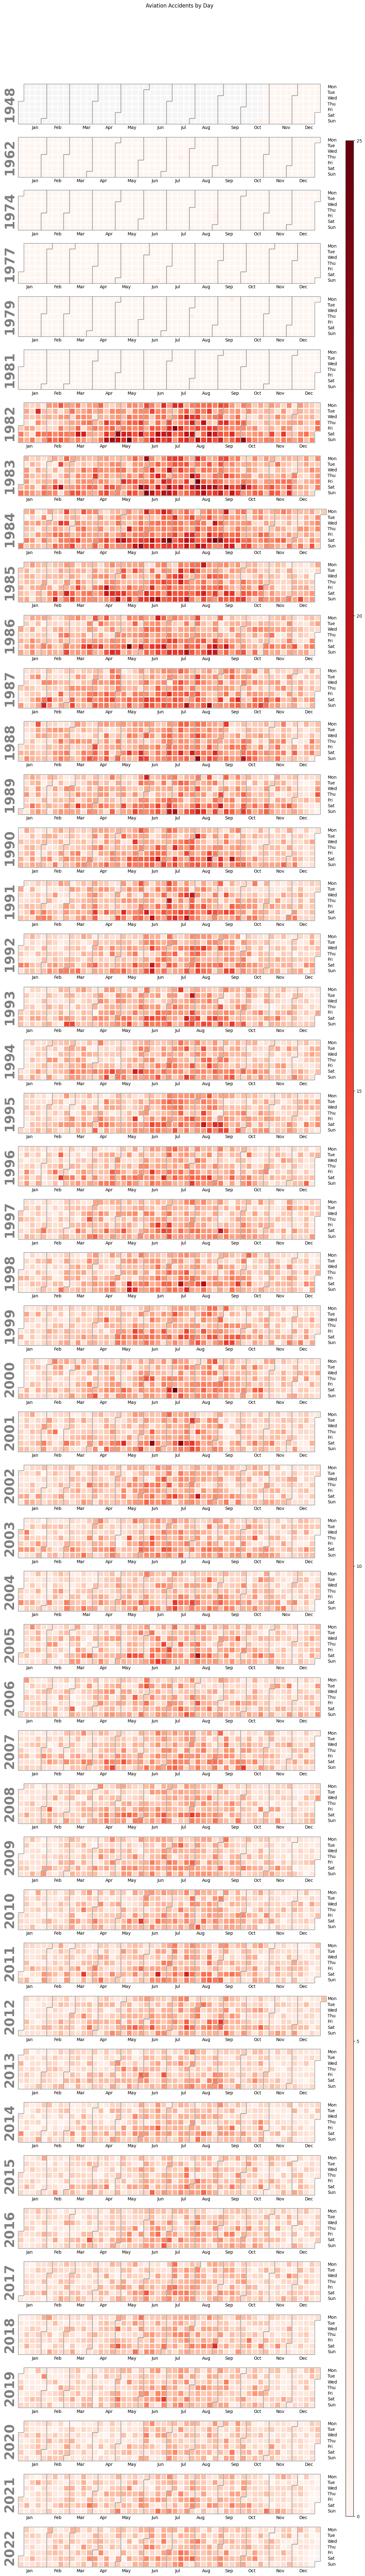

In [ ]:
#5.2

#Plot the events on a calendar heat map

import calplot


df['event_date'] = pd.to_datetime(df['event_date'])

# Get the number of events that occured on the day
daily_counts = df.groupby('event_date').size()

# Plot on calendar heatmap
calplot.calplot(daily_counts, cmap="Reds", suptitle="Aviation Accidents by Day")

From the map it shows that Florida, Texas and California have the highest rates of accidents. From the calendar it seems that most accidents occur during the summer months.


Question 6: Open-Ended Analysis (10 points)
Perform a comparative analysis of your choice. Ensure that you provide accurate information and compelling visual storytelling with the data. Explain all steps and justify your analysis based on the supporting data.
Create at least 5 visualizations that tell a complete story about your chosen comparison.



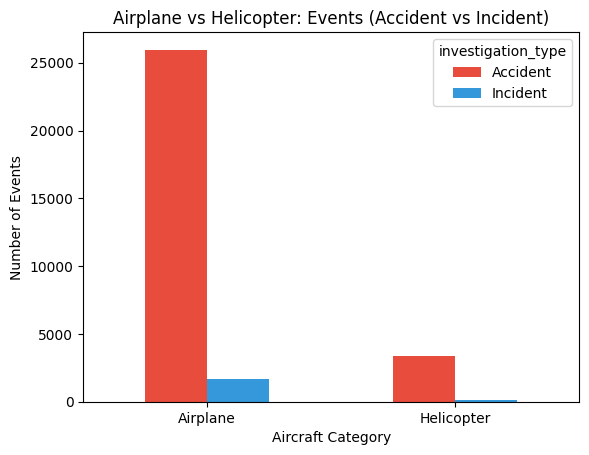

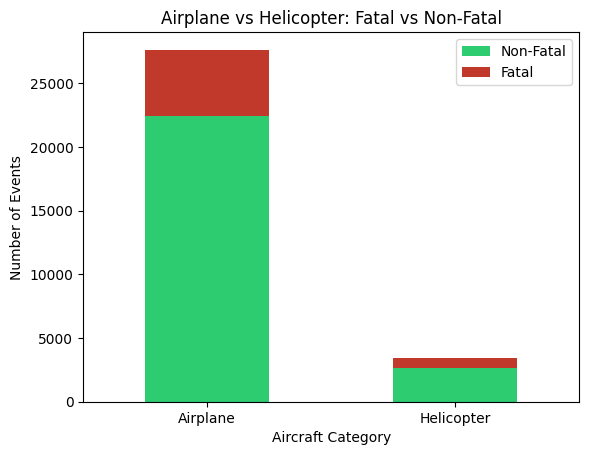

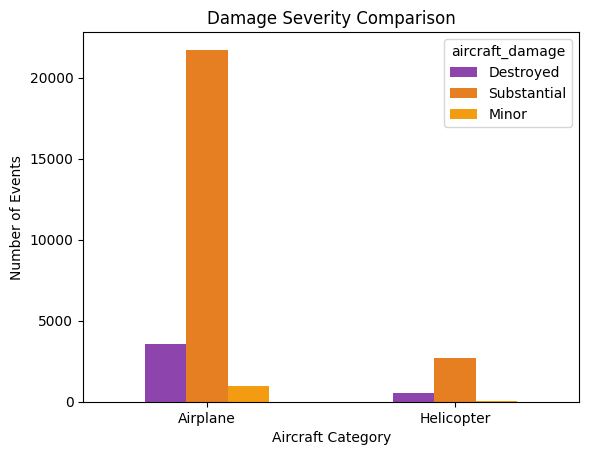

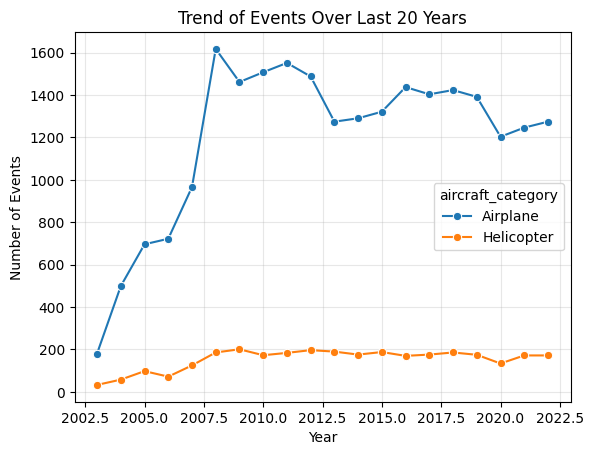

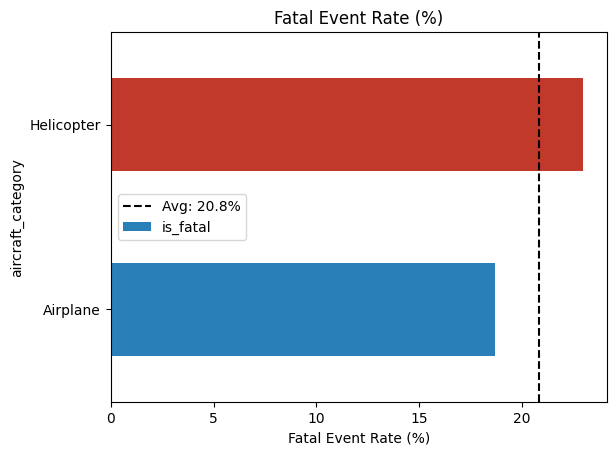

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/itsayaanpatel/NTSB-Analysis/main/Downloads/NTSBdata/NTSBAviationData.csv"
df = pd.read_csv(url, encoding='latin1', low_memory=False)

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(".", "_")
df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")
df = df.dropna(subset=["event_date"])

injury_cols = ["total_fatal_injuries","total_serious_injuries","total_minor_injuries","total_uninjured"]
for col in injury_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df['is_fatal'] = df['total_fatal_injuries'].fillna(0) > 0
df['year'] = df['event_date'].dt.year

df_categories = df[df['aircraft_category'].isin(['Airplane', 'Helicopter'])].copy()

# 1. Accidents vs Incidents
event_compare = df_categories.groupby(['aircraft_category','investigation_type']).size().unstack(fill_value=0)
event_compare.plot(kind='bar', color=['#e74c3c','#3498db'])
plt.title('Airplane vs Helicopter: Events (Accident vs Incident)')
plt.ylabel('Number of Events')
plt.xlabel('Aircraft Category')
plt.xticks(rotation=0)
plt.show()

# 2. Fatal vs Non-Fatal
fatal_compare = df_categories.groupby(['aircraft_category','is_fatal']).size().unstack(fill_value=0)
fatal_compare.columns = ['Non-Fatal','Fatal']
fatal_compare.plot(kind='bar', stacked=True, color=['#2ecc71','#c0392b'])
plt.title('Airplane vs Helicopter: Fatal vs Non-Fatal')
plt.ylabel('Number of Events')
plt.xlabel('Aircraft Category')
plt.xticks(rotation=0)
plt.show()

# 3. Damage Severity
damage_data = df_categories[df_categories['aircraft_damage'].notna()]
damage_compare = pd.crosstab(damage_data['aircraft_category'], damage_data['aircraft_damage'])
if all(x in damage_compare.columns for x in ['Destroyed','Substantial','Minor']):
    damage_compare = damage_compare[['Destroyed','Substantial','Minor']]
damage_compare.plot(kind='bar', color=['#8e44ad','#e67e22','#f39c12'])
plt.title('Damage Severity Comparison')
plt.ylabel('Number of Events')
plt.xlabel('Aircraft Category')
plt.xticks(rotation=0)
plt.show()

# 4. Temporal Trends
recent_years = sorted(df_categories['year'].dropna().unique())[-20:]
trend_data = df_categories[df_categories['year'].isin(recent_years)].groupby(['year','aircraft_category']).size().reset_index(name='count')
sns.lineplot(data=trend_data, x='year', y='count', hue='aircraft_category', marker="o")
plt.title('Trend of Events Over Last 20 Years')
plt.ylabel('Number of Events')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.show()

# 5. Fatal Event Rate
fatal_rate = df_categories.groupby('aircraft_category')['is_fatal'].mean() * 100
fatal_rate.plot(kind='barh', color=['#2980b9','#c0392b'])
plt.title('Fatal Event Rate (%)')
plt.xlabel('Fatal Event Rate (%)')
plt.axvline(fatal_rate.mean(), color='black', linestyle='--', label=f'Avg: {fatal_rate.mean():.1f}%')
plt.legend()
plt.show()


Comparative Analysis: Airplanes vs Helicopters
For this open-ended analysis, I compared Airplanes and Helicopters, the two most common aircraft categories in the NTSB dataset. The goal was to evaluate which category has more accidents, how severe they are, and whether safety has changed over time.
1. Total Events (Accidents vs Incidents)
The first chart shows that airplanes account for a larger share of total recorded events compared to helicopters. This is expected, since airplanes are more widely used in commercial and general aviation. However, this only reflects absolute usage volume, not relative safety.
2. Fatal vs Non-Fatal Events
When comparing the outcome of events, helicopters show a higher proportion of fatal accidents relative to airplanes. Even though airplanes have more events overall, a greater share of helicopter events result in fatalities.
3. Damage Severity
The damage severity distribution reinforces this pattern. Helicopters have more “Destroyed” classifications than airplanes, while airplanes more frequently fall into “Substantial” or “Minor” damage. This suggests helicopter crashes are often more catastrophic.
4. Temporal Trends (Last 20 Years)
Looking at the last 20 years, airplane accidents and incidents show a general decline, reflecting improvements in safety standards, regulation, and technology. In contrast, helicopter event counts remain relatively flat, indicating slower improvement in helicopter safety.
5. Fatal Event Rate (%)
Finally, the fatal event rate makes the risk profile clear: helicopters have a noticeably higher fatal event rate than airplanes, even after accounting for total usage. This means that per accident, helicopters are riskier to operate.
Conclusion
Together, these five visualizations tell a consistent story:
Airplanes dominate in total number of events, which reflects their higher utilization.
Helicopters are relatively more dangerous, with higher fatality proportions, higher rates of catastrophic damage, and less improvement over time.
This comparative analysis highlights how different types of aircraft carry different levels of risk — airplanes are more frequent in accidents, but helicopters are more often deadly.

#Question 7: Summary (5 points)
Summarize the overall analysis and share THREE (3) key findings, 2 critical recommendations and your aviation safety assessment.

## Key Findings

1. Fatal or serious injuries have gradually been declining dues to improvement in technology over the last couple of years.

2. Most accidents involve single-engline planes.

3. Accidents are concentrated during the summer months, and usually concentrated in Florida, California and Texas.

## Recommendations:

1. More frequent inspections for specific models with high accident rates
2.